# Outlier Detection & Treatment - Hotel Reservations Dataset

## 1. Import Libraries and Load Data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [23]:
# Load the dataset
df = pd.read_csv("Hotel_Reservations_Engineered.csv")
print(f"Original dataset shape: {df.shape}")
print(f"Total records: {len(df):,}")

# Create a copy for treatment
df_treated = df.copy()

df.head()

Original dataset shape: (36275, 30)
Total records: 36,275


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,total_guests,lead_time_category,avg_price_per_guest,has_weekend_nights,booking_value,special_treatment_index,customer_loyalty_score,arrival_season,booking_complexity_score,booking_status_binary
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,...,2,Long,32.50,1,195.0,0,0,Fall,0.077273,0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,...,2,Short,53.34,1,533.4,1,0,Fall,0.170606,0
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,...,1,Short,60.00,1,180.0,0,0,Winter,0.050000,1
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,...,2,Long,50.00,0,200.0,0,0,Spring,0.060606,1
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,...,2,Medium,47.25,1,189.0,0,0,Spring,0.060606,1


## 2. Identify Numerical Columns

In [24]:
# Select numerical columns (excluding ID)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Booking_ID' in numerical_cols:
    numerical_cols.remove('Booking_ID')

print("Numerical columns for outlier analysis:")
for i, col in enumerate(numerical_cols, 1):
    print(f"{i}. {col}")

Numerical columns for outlier analysis:
1. no_of_adults
2. no_of_children
3. no_of_weekend_nights
4. no_of_week_nights
5. required_car_parking_space
6. lead_time
7. arrival_year
8. arrival_month
9. arrival_date
10. repeated_guest
11. no_of_previous_cancellations
12. no_of_previous_bookings_not_canceled
13. avg_price_per_room
14. no_of_special_requests
15. total_stay_nights
16. total_guests
17. avg_price_per_guest
18. has_weekend_nights
19. booking_value
20. special_treatment_index
21. customer_loyalty_score
22. booking_complexity_score
23. booking_status_binary


## 3. Outlier Detection Methods

We'll use three methods to detect outliers:
1. **IQR (Interquartile Range) Method** - Most common, robust to extreme values
2. **Z-Score Method** - Assumes normal distribution
3. **Visual Inspection** - Box plots and distribution plots

### 3.1 IQR Method

In [25]:
def detect_outliers_iqr(data, column, multiplier=1.5):
    """
    Detect outliers using IQR method.
    
    Parameters:
    - data: DataFrame
    - column: Column name
    - multiplier: IQR multiplier (default 1.5 for outliers, 3.0 for extreme outliers)
    
    Returns:
    - Dictionary with outlier information
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    return {
        'column': column,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'n_outliers': len(outliers),
        'outlier_percentage': (len(outliers) / len(data)) * 100,
        'outlier_indices': outliers.index.tolist()
    }

# Detect outliers for all numerical columns
outlier_summary_iqr = {}
for col in numerical_cols:
    outlier_summary_iqr[col] = detect_outliers_iqr(df, col)

# Display summary
print("="*100)
print("OUTLIER DETECTION - IQR METHOD (1.5 * IQR)")
print("="*100)
print(f"\n{'Column':<40} {'Outliers':<12} {'Percentage':<12} {'Lower Bound':<15} {'Upper Bound':<15}")
print("-"*100)

for col, info in outlier_summary_iqr.items():
    print(f"{col:<40} {info['n_outliers']:<12} {info['outlier_percentage']:<12.2f} {info['lower_bound']:<15.2f} {info['upper_bound']:<15.2f}")

OUTLIER DETECTION - IQR METHOD (1.5 * IQR)

Column                                   Outliers     Percentage   Lower Bound     Upper Bound    
----------------------------------------------------------------------------------------------------
no_of_adults                             10167        28.03        2.00            2.00           
no_of_children                           2698         7.44         0.00            0.00           
no_of_weekend_nights                     21           0.06         -3.00           5.00           
no_of_week_nights                        324          0.89         -2.00           6.00           
required_car_parking_space               1124         3.10         0.00            0.00           
lead_time                                1331         3.67         -146.50         289.50         
arrival_year                             6514         17.96        2018.00         2018.00        
arrival_month                            0            0.00     

### 3.2 Z-Score Method

In [26]:
def detect_outliers_zscore(data, column, threshold=3):
    """
    Detect outliers using Z-score method.
    
    Parameters:
    - data: DataFrame
    - column: Column name
    - threshold: Z-score threshold (default 3)
    
    Returns:
    - Dictionary with outlier information
    """
    z_scores = np.abs(stats.zscore(data[column]))
    outliers = data[z_scores > threshold]
    
    return {
        'column': column,
        'threshold': threshold,
        'n_outliers': len(outliers),
        'outlier_percentage': (len(outliers) / len(data)) * 100,
        'outlier_indices': outliers.index.tolist()
    }

# Detect outliers using Z-score
outlier_summary_zscore = {}
for col in numerical_cols:
    outlier_summary_zscore[col] = detect_outliers_zscore(df, col)

# Display summary
print("\n" + "="*80)
print("OUTLIER DETECTION - Z-SCORE METHOD (threshold = 3)")
print("="*80)
print(f"\n{'Column':<40} {'Outliers':<12} {'Percentage':<12}")
print("-"*80)

for col, info in outlier_summary_zscore.items():
    print(f"{col:<40} {info['n_outliers']:<12} {info['outlier_percentage']:<12.2f}")


OUTLIER DETECTION - Z-SCORE METHOD (threshold = 3)

Column                                   Outliers     Percentage  
--------------------------------------------------------------------------------
no_of_adults                             155          0.43        
no_of_children                           1080         2.98        
no_of_weekend_nights                     184          0.51        
no_of_week_nights                        324          0.89        
required_car_parking_space               1124         3.10        
lead_time                                376          1.04        
arrival_year                             0            0.00        
arrival_month                            0            0.00        
arrival_date                             0            0.00        
repeated_guest                           930          2.56        
no_of_previous_cancellations             140          0.39        
no_of_previous_bookings_not_canceled     267          0.74    

### 3.3 Visual Inspection - Box Plots

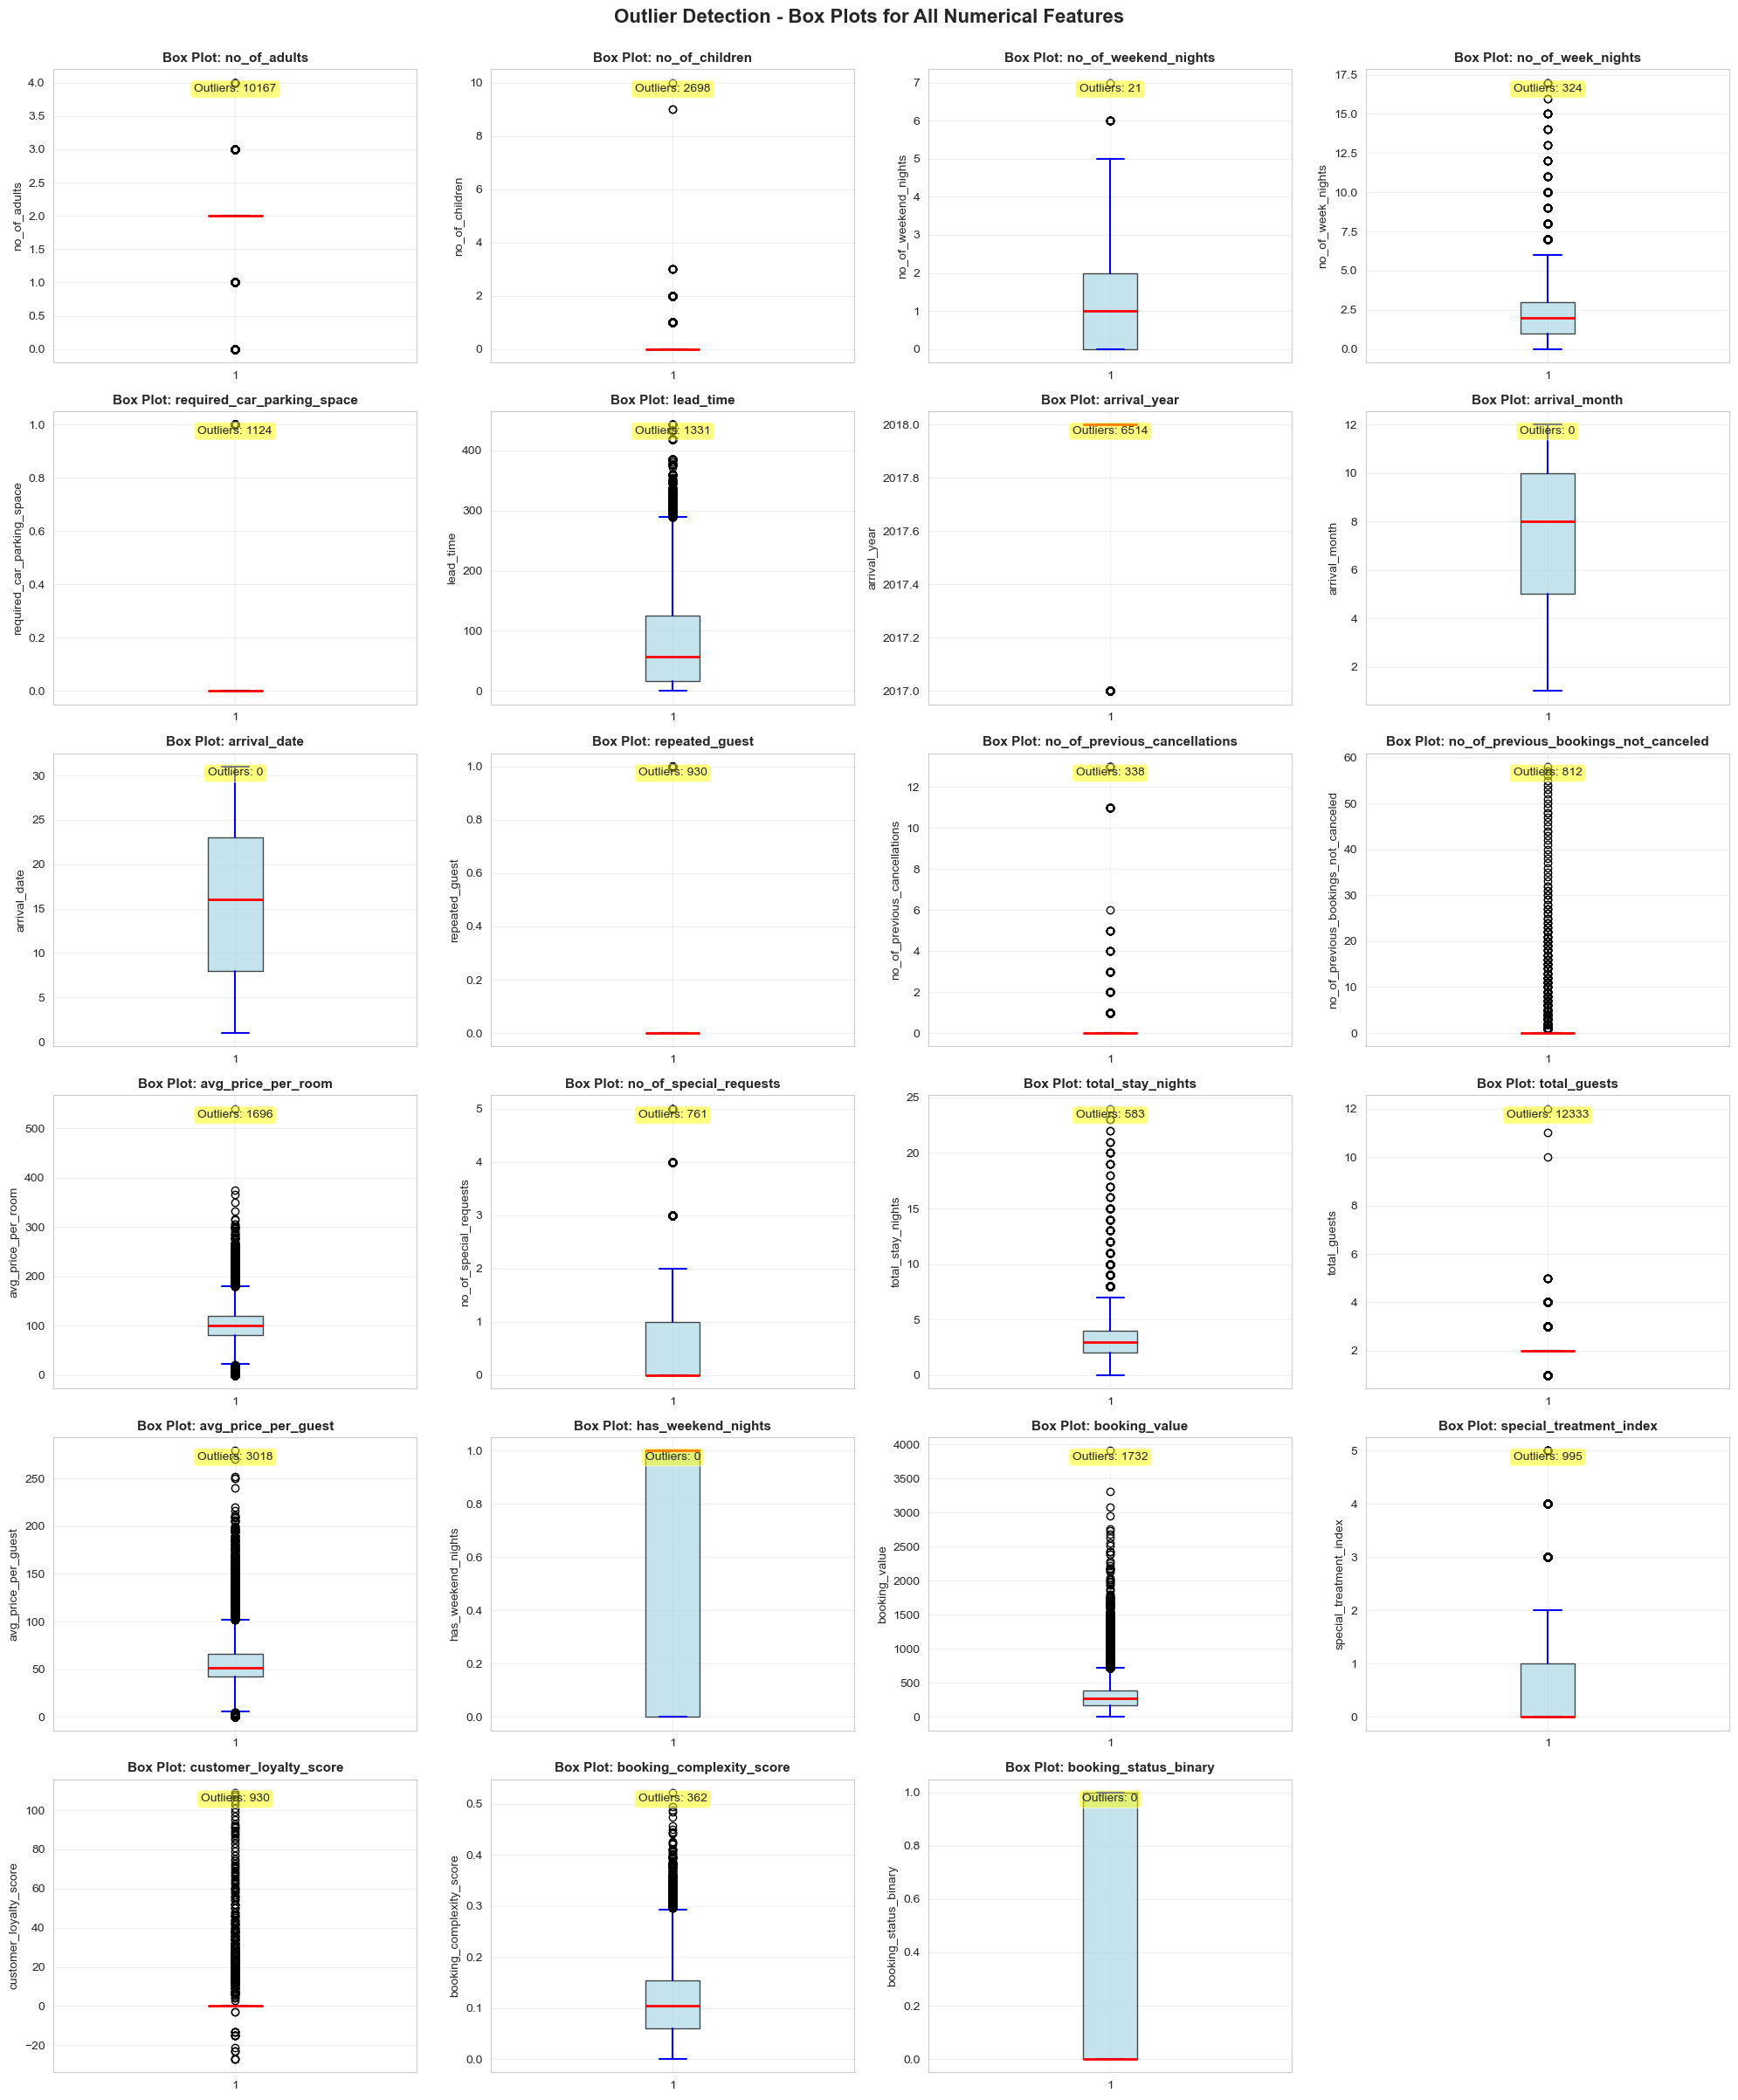

In [27]:
# Create box plots for all numerical features
n_cols = 4
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].boxplot(df[col].dropna(), vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='blue', linewidth=1.5),
                     capprops=dict(color='blue', linewidth=1.5))
    axes[idx].set_title(f'Box Plot: {col}', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)
    
    # Add outlier count
    n_outliers = outlier_summary_iqr[col]['n_outliers']
    axes[idx].text(0.5, 0.95, f'Outliers: {n_outliers}', 
                  transform=axes[idx].transAxes, 
                  ha='center', va='top',
                  bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Hide extra subplots
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Outlier Detection - Box Plots for All Numerical Features', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 3.4 Distribution Plots with Outlier Boundaries

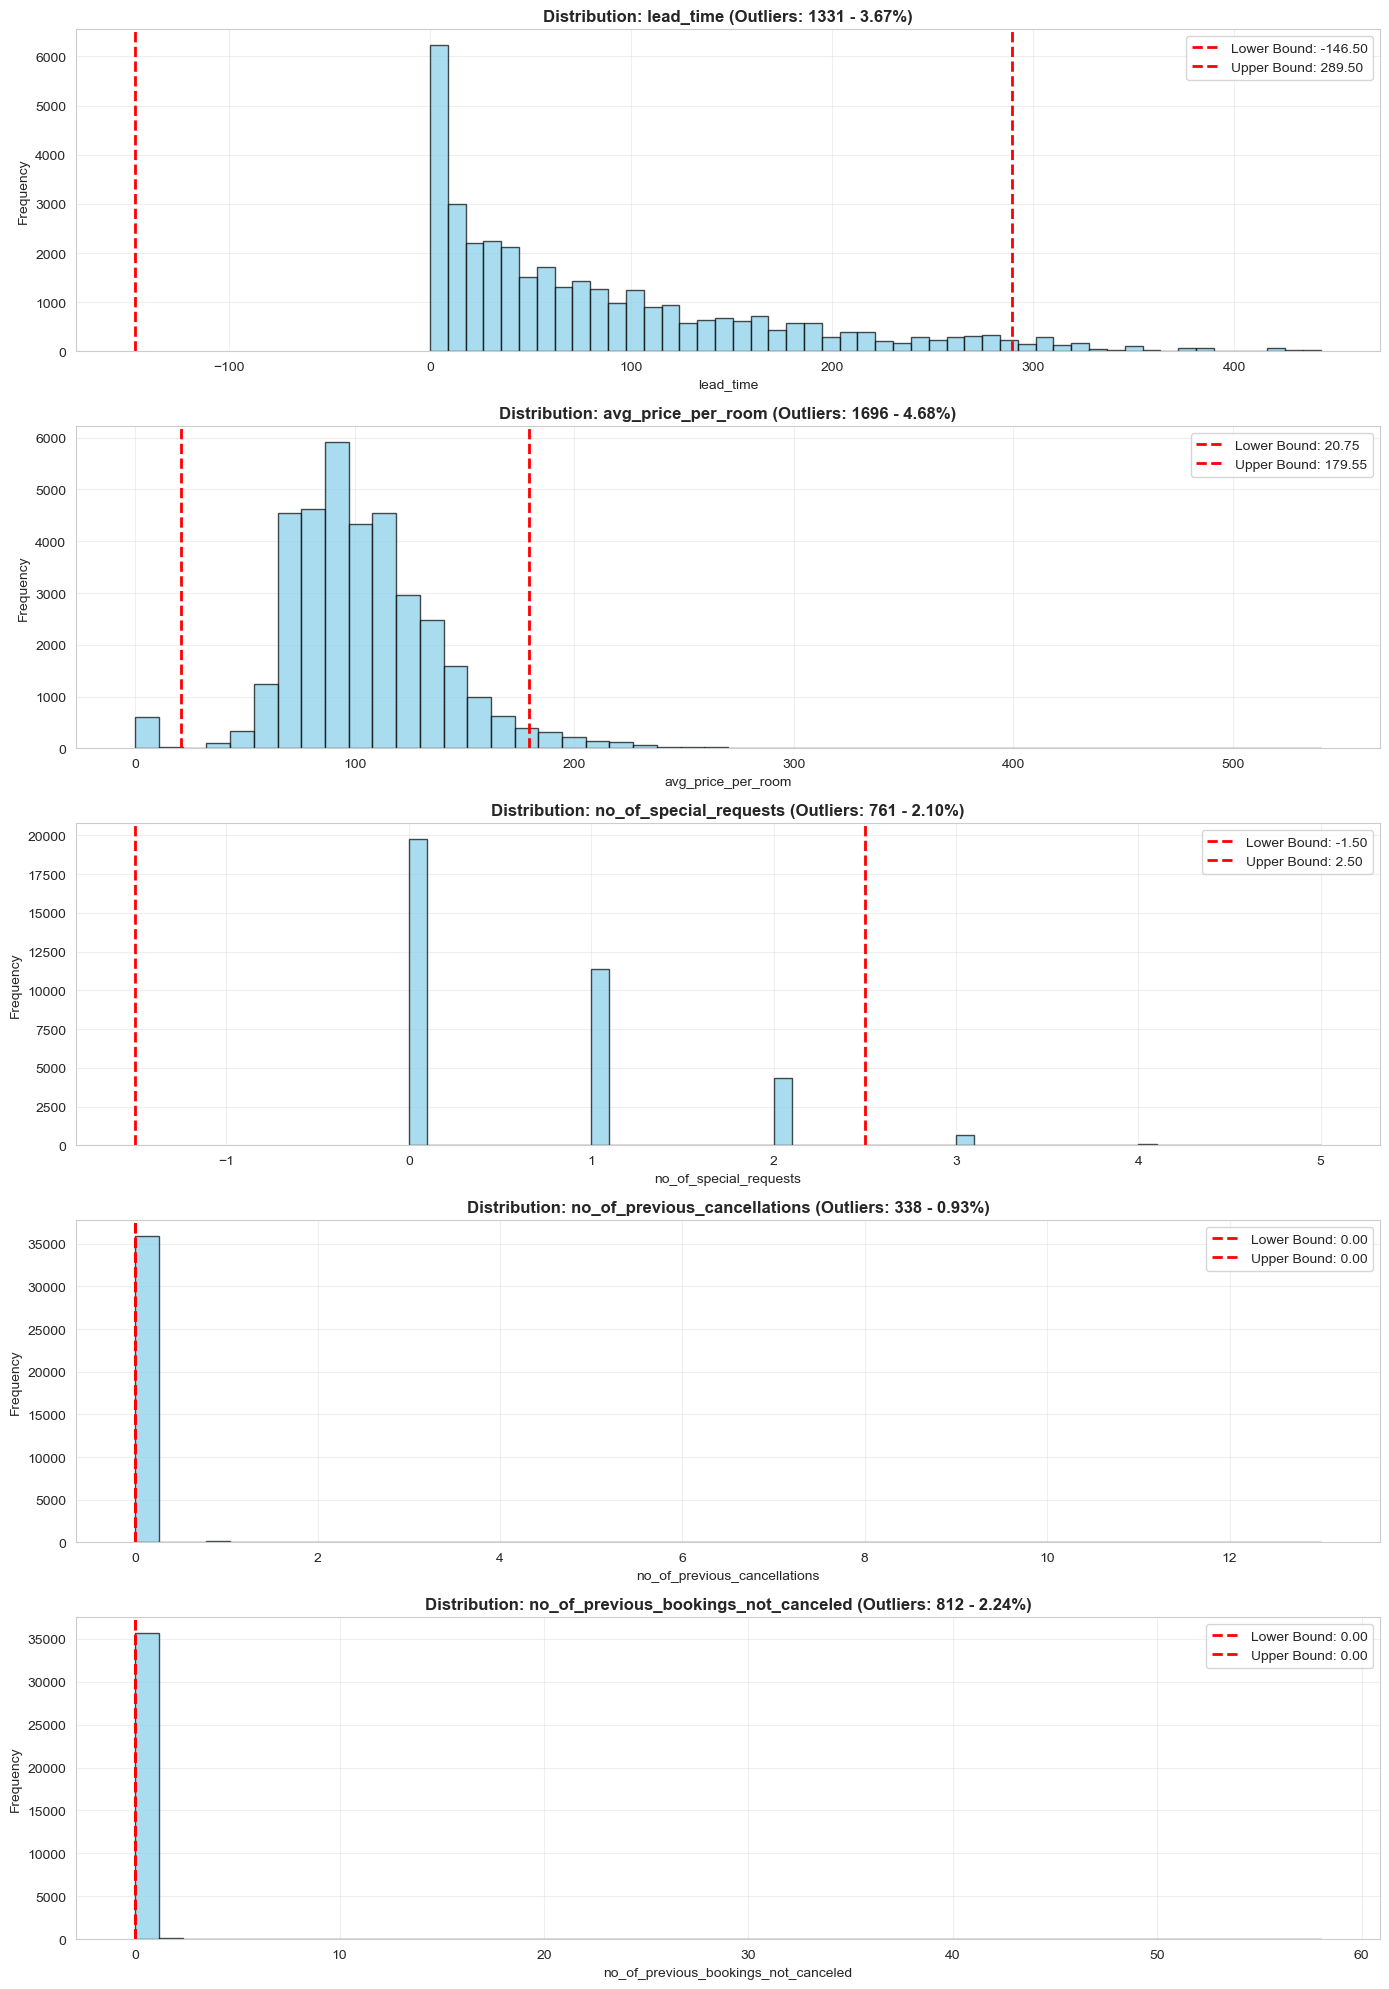

In [28]:
# Focus on key features with significant outliers
key_features = ['lead_time', 'avg_price_per_room', 'no_of_special_requests', 
                'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled']

fig, axes = plt.subplots(len(key_features), 1, figsize=(14, len(key_features) * 4))

for idx, col in enumerate(key_features):
    # Histogram
    axes[idx].hist(df[col], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    
    # Add IQR boundaries
    info = outlier_summary_iqr[col]
    axes[idx].axvline(info['lower_bound'], color='red', linestyle='--', linewidth=2, 
                     label=f"Lower Bound: {info['lower_bound']:.2f}")
    axes[idx].axvline(info['upper_bound'], color='red', linestyle='--', linewidth=2,
                     label=f"Upper Bound: {info['upper_bound']:.2f}")
    
    axes[idx].set_title(f'Distribution: {col} (Outliers: {info["n_outliers"]} - {info["outlier_percentage"]:.2f}%)',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Detailed Analysis of Key Features

### 4.1 Lead Time Analysis

In [29]:
print("="*80)
print("LEAD TIME - DETAILED ANALYSIS")
print("="*80)

print("\nStatistical Summary:")
print(df['lead_time'].describe())

info = outlier_summary_iqr['lead_time']
print(f"\nIQR Method:")
print(f"  Q1: {info['Q1']:.2f}")
print(f"  Q3: {info['Q3']:.2f}")
print(f"  IQR: {info['IQR']:.2f}")
print(f"  Lower Bound: {info['lower_bound']:.2f}")
print(f"  Upper Bound: {info['upper_bound']:.2f}")
print(f"  Outliers: {info['n_outliers']} ({info['outlier_percentage']:.2f}%)")

# Check if outliers are legitimate
outlier_lead_times = df.loc[info['outlier_indices'], 'lead_time']
print(f"\nOutlier Lead Time Range: {outlier_lead_times.min():.0f} - {outlier_lead_times.max():.0f} days")
print(f"\nTop 10 highest lead times:")
print(df.nlargest(10, 'lead_time')[['Booking_ID', 'lead_time', 'booking_status']])

LEAD TIME - DETAILED ANALYSIS

Statistical Summary:
count    36275.000000
mean        85.232557
std         85.930817
min          0.000000
25%         17.000000
50%         57.000000
75%        126.000000
max        443.000000
Name: lead_time, dtype: float64

IQR Method:
  Q1: 17.00
  Q3: 126.00
  IQR: 109.00
  Lower Bound: -146.50
  Upper Bound: 289.50
  Outliers: 1331 (3.67%)

Outlier Lead Time Range: 290 - 443 days

Top 10 highest lead times:
      Booking_ID  lead_time booking_status
118     INN00119        443       Canceled
1943    INN01944        443       Canceled
2279    INN02280        443       Canceled
3146    INN03147        443       Canceled
3373    INN03374        443       Canceled
3746    INN03747        443       Canceled
5211    INN05212        443       Canceled
11147   INN11148        443       Canceled
12625   INN12626        443       Canceled
19141   INN19142        443       Canceled


### 4.2 Average Price Per Room Analysis

In [30]:
print("="*80)
print("AVERAGE PRICE PER ROOM - DETAILED ANALYSIS")
print("="*80)

print("\nStatistical Summary:")
print(df['avg_price_per_room'].describe())

info = outlier_summary_iqr['avg_price_per_room']
print(f"\nIQR Method:")
print(f"  Q1: ${info['Q1']:.2f}")
print(f"  Q3: ${info['Q3']:.2f}")
print(f"  IQR: ${info['IQR']:.2f}")
print(f"  Lower Bound: ${info['lower_bound']:.2f}")
print(f"  Upper Bound: ${info['upper_bound']:.2f}")
print(f"  Outliers: {info['n_outliers']} ({info['outlier_percentage']:.2f}%)")

# Check price distribution
print(f"\nPrice = 0: {(df['avg_price_per_room'] == 0).sum()} records")
print(f"Price > $300: {(df['avg_price_per_room'] > 300).sum()} records")

print(f"\nTop 10 highest prices:")
print(df.nlargest(10, 'avg_price_per_room')[['Booking_ID', 'avg_price_per_room', 'room_type_reserved', 'booking_status']])

AVERAGE PRICE PER ROOM - DETAILED ANALYSIS

Statistical Summary:
count    36275.000000
mean       103.423539
std         35.089424
min          0.000000
25%         80.300000
50%         99.450000
75%        120.000000
max        540.000000
Name: avg_price_per_room, dtype: float64

IQR Method:
  Q1: $80.30
  Q3: $120.00
  IQR: $39.70
  Lower Bound: $20.75
  Upper Bound: $179.55
  Outliers: 1696 (4.68%)

Price = 0: 545 records
Price > $300: 9 records

Top 10 highest prices:
      Booking_ID  avg_price_per_room room_type_reserved booking_status
33114   INN33115              540.00        Room_Type 1       Canceled
9461    INN09462              375.50        Room_Type 4   Not_Canceled
20900   INN20901              365.00        Room_Type 1       Canceled
34306   INN34307              349.63        Room_Type 6   Not_Canceled
14773   INN14774              332.57        Room_Type 6   Not_Canceled
13944   INN13945              316.00        Room_Type 6       Canceled
33955   INN33956         

## 5. Outlier Treatment Strategies

We'll apply different treatment methods based on the nature of each feature.

### 5.1 Lead Time - Capping (Winsorization)

**Reasoning**: 
- Lead times > 443 days are rare but legitimate (early planners)
- Removing them would lose valuable information
- Capping at 95th percentile preserves the pattern while reducing extreme influence

Lead Time Percentiles:
  95th percentile: 273 days
  99th percentile: 346 days
  Maximum: 443 days

After capping at 99th percentile:
  Records affected: 302
  New maximum: 346 days


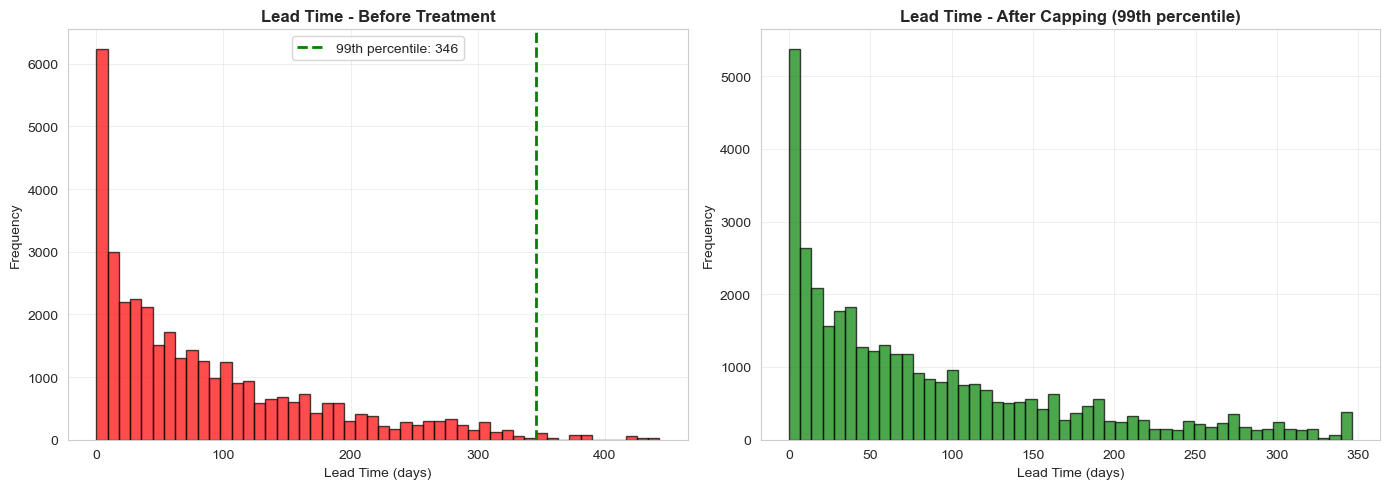

In [31]:
# Calculate percentiles for capping
lead_time_95th = df['lead_time'].quantile(0.95)
lead_time_99th = df['lead_time'].quantile(0.99)

print(f"Lead Time Percentiles:")
print(f"  95th percentile: {lead_time_95th:.0f} days")
print(f"  99th percentile: {lead_time_99th:.0f} days")
print(f"  Maximum: {df['lead_time'].max():.0f} days")

# Apply capping at 99th percentile
df_treated['lead_time_capped'] = df_treated['lead_time'].clip(upper=lead_time_99th)

print(f"\nAfter capping at 99th percentile:")
print(f"  Records affected: {(df['lead_time'] > lead_time_99th).sum()}")
print(f"  New maximum: {df_treated['lead_time_capped'].max():.0f} days")

# Visualize before and after
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['lead_time'], bins=50, edgecolor='black', alpha=0.7, color='red')
axes[0].set_title('Lead Time - Before Treatment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lead Time (days)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(lead_time_99th, color='green', linestyle='--', linewidth=2, label=f'99th percentile: {lead_time_99th:.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_treated['lead_time_capped'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Lead Time - After Capping (99th percentile)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lead Time (days)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Average Price Per Room - Handling Zero Values and Capping

**Reasoning**:
- Zero prices likely indicate promotional/complimentary stays (legitimate)
- Very high prices (> $300) are luxury bookings (legitimate)
- We'll keep zeros but cap extreme high values at 99th percentile

Records with zero price: 545 (1.50%)

Booking status for zero-price records:
booking_status
Not_Canceled    539
Canceled          6
Name: count, dtype: int64

Price Percentiles (non-zero):
  99th percentile: $208.65
  Maximum: $540.00

After capping at 99th percentile:
  Records affected: 358
  New maximum: $208.65


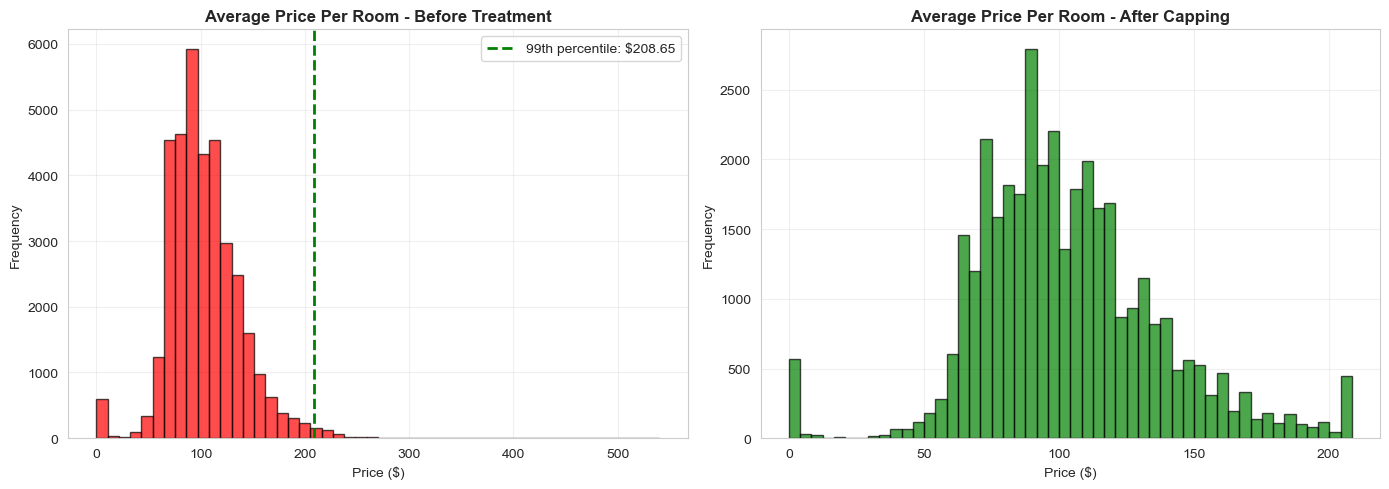

In [32]:
# Analyze zero prices
zero_price_count = (df['avg_price_per_room'] == 0).sum()
print(f"Records with zero price: {zero_price_count} ({(zero_price_count/len(df))*100:.2f}%)")

# Check booking status for zero prices
if zero_price_count > 0:
    print("\nBooking status for zero-price records:")
    print(df[df['avg_price_per_room'] == 0]['booking_status'].value_counts())

# Calculate percentiles (excluding zeros for upper bound)
price_non_zero = df[df['avg_price_per_room'] > 0]['avg_price_per_room']
price_99th = price_non_zero.quantile(0.99)

print(f"\nPrice Percentiles (non-zero):")
print(f"  99th percentile: ${price_99th:.2f}")
print(f"  Maximum: ${df['avg_price_per_room'].max():.2f}")

# Apply capping (keep zeros, cap high values)
df_treated['avg_price_per_room_capped'] = df_treated['avg_price_per_room'].clip(upper=price_99th)

print(f"\nAfter capping at 99th percentile:")
print(f"  Records affected: {(df['avg_price_per_room'] > price_99th).sum()}")
print(f"  New maximum: ${df_treated['avg_price_per_room_capped'].max():.2f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['avg_price_per_room'], bins=50, edgecolor='black', alpha=0.7, color='red')
axes[0].set_title('Average Price Per Room - Before Treatment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(price_99th, color='green', linestyle='--', linewidth=2, label=f'99th percentile: ${price_99th:.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_treated['avg_price_per_room_capped'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Average Price Per Room - After Capping', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Price ($)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Special Requests - Keep As Is

**Reasoning**:
- Special requests range from 0-5, all legitimate values
- No extreme outliers detected
- Values represent actual customer behavior
- **Decision: No treatment needed**

In [33]:
print("Special Requests Analysis:")
print(f"\nValue distribution:")
print(df['no_of_special_requests'].value_counts().sort_index())
print(f"\nRange: {df['no_of_special_requests'].min()} - {df['no_of_special_requests'].max()}")
print(f"\nOutliers (IQR method): {outlier_summary_iqr['no_of_special_requests']['n_outliers']}")
print("\n✓ Decision: No treatment needed - all values are legitimate")

df_treated['no_of_special_requests_treated'] = df_treated['no_of_special_requests']

Special Requests Analysis:

Value distribution:
no_of_special_requests
0    19777
1    11373
2     4364
3      675
4       78
5        8
Name: count, dtype: int64

Range: 0 - 5

Outliers (IQR method): 761

✓ Decision: No treatment needed - all values are legitimate


### 5.4 Previous Cancellations - Log Transformation

**Reasoning**:
- Highly right-skewed distribution
- Most values are 0, with few extreme values (up to 13)
- Log transformation reduces skewness while preserving information
- Use log1p to handle zeros

Previous Cancellations Analysis:

Value distribution:
no_of_previous_cancellations
0     35937
1       198
2        46
3        43
4        10
5        11
6         1
11       25
13        4
Name: count, dtype: int64

Range: 0 - 13
Zeros: 35937 (99.07%)


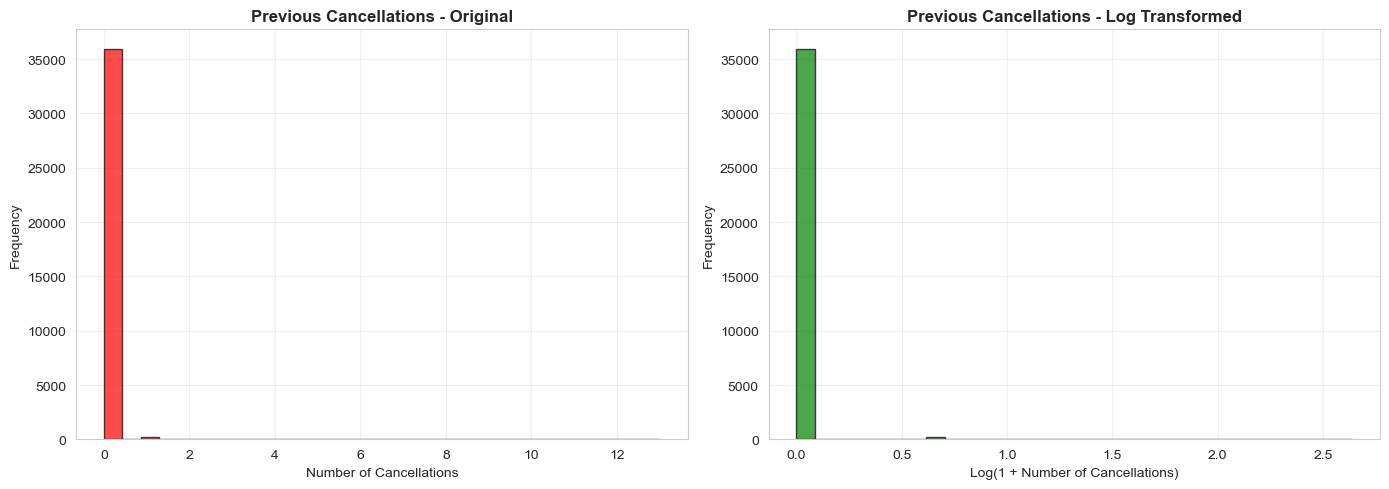


✓ Applied log1p transformation to reduce skewness


In [34]:
print("Previous Cancellations Analysis:")
print(f"\nValue distribution:")
print(df['no_of_previous_cancellations'].value_counts().sort_index().head(10))
print(f"\nRange: {df['no_of_previous_cancellations'].min()} - {df['no_of_previous_cancellations'].max()}")
print(f"Zeros: {(df['no_of_previous_cancellations'] == 0).sum()} ({(df['no_of_previous_cancellations'] == 0).sum()/len(df)*100:.2f}%)")

# Apply log transformation (log1p handles zeros)
df_treated['no_of_previous_cancellations_log'] = np.log1p(df_treated['no_of_previous_cancellations'])

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['no_of_previous_cancellations'], bins=30, edgecolor='black', alpha=0.7, color='red')
axes[0].set_title('Previous Cancellations - Original', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Cancellations')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_treated['no_of_previous_cancellations_log'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Previous Cancellations - Log Transformed', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Log(1 + Number of Cancellations)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Applied log1p transformation to reduce skewness")

### 5.5 Previous Bookings Not Canceled - Log Transformation

**Reasoning**:
- Similar to previous cancellations, highly right-skewed
- Most values are 0, with some extreme values (up to 58)
- Log transformation appropriate for this distribution

Previous Bookings Not Canceled Analysis:

Basic statistics:
count    36275.000000
mean         0.153411
std          1.754171
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         58.000000
Name: no_of_previous_bookings_not_canceled, dtype: float64

Zeros: 35463 (97.76%)


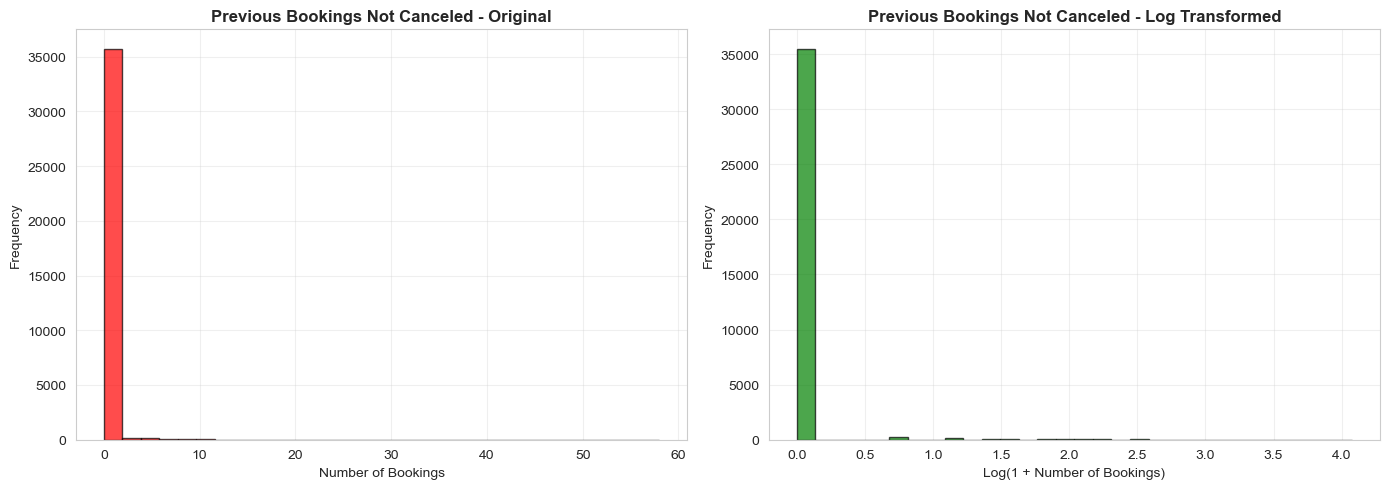


✓ Applied log1p transformation to reduce skewness


In [35]:
print("Previous Bookings Not Canceled Analysis:")
print(f"\nBasic statistics:")
print(df['no_of_previous_bookings_not_canceled'].describe())
print(f"\nZeros: {(df['no_of_previous_bookings_not_canceled'] == 0).sum()} ({(df['no_of_previous_bookings_not_canceled'] == 0).sum()/len(df)*100:.2f}%)")

# Apply log transformation
df_treated['no_of_previous_bookings_not_canceled_log'] = np.log1p(df_treated['no_of_previous_bookings_not_canceled'])

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['no_of_previous_bookings_not_canceled'], bins=30, edgecolor='black', alpha=0.7, color='red')
axes[0].set_title('Previous Bookings Not Canceled - Original', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Bookings')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_treated['no_of_previous_bookings_not_canceled_log'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Previous Bookings Not Canceled - Log Transformed', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Log(1 + Number of Bookings)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Applied log1p transformation to reduce skewness")

### 5.6 Other Numerical Features - Assessment

In [36]:
# Assess remaining features
other_features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 
                  'no_of_week_nights', 'required_car_parking_space', 
                  'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest']

print("="*80)
print("ASSESSMENT OF OTHER NUMERICAL FEATURES")
print("="*80)

for feature in other_features:
    if feature in numerical_cols:
        info = outlier_summary_iqr[feature]
        print(f"\n{feature}:")
        print(f"  Range: {df[feature].min()} - {df[feature].max()}")
        print(f"  Outliers: {info['n_outliers']} ({info['outlier_percentage']:.2f}%)")
        
        # Decision logic
        if info['outlier_percentage'] < 1 and df[feature].max() <= 20:
            print(f"  ✓ Decision: Keep as is (small range, few outliers)")
            df_treated[f'{feature}_treated'] = df_treated[feature]
        else:
            print(f"  → Requires review")

ASSESSMENT OF OTHER NUMERICAL FEATURES

no_of_adults:
  Range: 0 - 4
  Outliers: 10167 (28.03%)
  → Requires review

no_of_children:
  Range: 0 - 10
  Outliers: 2698 (7.44%)
  → Requires review

no_of_weekend_nights:
  Range: 0 - 7
  Outliers: 21 (0.06%)
  ✓ Decision: Keep as is (small range, few outliers)

no_of_week_nights:
  Range: 0 - 17
  Outliers: 324 (0.89%)
  ✓ Decision: Keep as is (small range, few outliers)

required_car_parking_space:
  Range: 0 - 1
  Outliers: 1124 (3.10%)
  → Requires review

arrival_year:
  Range: 2017 - 2018
  Outliers: 6514 (17.96%)
  → Requires review

arrival_month:
  Range: 1 - 12
  Outliers: 0 (0.00%)
  ✓ Decision: Keep as is (small range, few outliers)

arrival_date:
  Range: 1 - 31
  Outliers: 0 (0.00%)
  → Requires review

repeated_guest:
  Range: 0 - 1
  Outliers: 930 (2.56%)
  → Requires review


## 6. Treatment Summary and Comparison

In [37]:
print("="*100)
print("OUTLIER TREATMENT SUMMARY")
print("="*100)

treatment_summary = [
    {
        'Feature': 'lead_time',
        'Outliers': outlier_summary_iqr['lead_time']['n_outliers'],
        'Percentage': f"{outlier_summary_iqr['lead_time']['outlier_percentage']:.2f}%",
        'Treatment': 'Capping at 99th percentile',
        'Reasoning': 'Preserve early planners while reducing extreme influence',
        'New Column': 'lead_time_capped'
    },
    {
        'Feature': 'avg_price_per_room',
        'Outliers': outlier_summary_iqr['avg_price_per_room']['n_outliers'],
        'Percentage': f"{outlier_summary_iqr['avg_price_per_room']['outlier_percentage']:.2f}%",
        'Treatment': 'Capping at 99th percentile',
        'Reasoning': 'Keep zero prices (promotional), cap luxury prices',
        'New Column': 'avg_price_per_room_capped'
    },
    {
        'Feature': 'no_of_special_requests',
        'Outliers': outlier_summary_iqr['no_of_special_requests']['n_outliers'],
        'Percentage': f"{outlier_summary_iqr['no_of_special_requests']['outlier_percentage']:.2f}%",
        'Treatment': 'No treatment',
        'Reasoning': 'All values (0-5) are legitimate customer behavior',
        'New Column': 'no_of_special_requests_treated'
    },
    {
        'Feature': 'no_of_previous_cancellations',
        'Outliers': outlier_summary_iqr['no_of_previous_cancellations']['n_outliers'],
        'Percentage': f"{outlier_summary_iqr['no_of_previous_cancellations']['outlier_percentage']:.2f}%",
        'Treatment': 'Log transformation (log1p)',
        'Reasoning': 'Reduce right skewness, handle zeros gracefully',
        'New Column': 'no_of_previous_cancellations_log'
    },
    {
        'Feature': 'no_of_previous_bookings_not_canceled',
        'Outliers': outlier_summary_iqr['no_of_previous_bookings_not_canceled']['n_outliers'],
        'Percentage': f"{outlier_summary_iqr['no_of_previous_bookings_not_canceled']['outlier_percentage']:.2f}%",
        'Treatment': 'Log transformation (log1p)',
        'Reasoning': 'Reduce right skewness, normalize distribution',
        'New Column': 'no_of_previous_bookings_not_canceled_log'
    }
]

summary_df = pd.DataFrame(treatment_summary)
print("\n")
print(summary_df.to_string(index=False))
print("\n" + "="*100)

OUTLIER TREATMENT SUMMARY


                             Feature  Outliers Percentage                  Treatment                                                Reasoning                               New Column
                           lead_time      1331      3.67% Capping at 99th percentile Preserve early planners while reducing extreme influence                         lead_time_capped
                  avg_price_per_room      1696      4.68% Capping at 99th percentile        Keep zero prices (promotional), cap luxury prices                avg_price_per_room_capped
              no_of_special_requests       761      2.10%               No treatment        All values (0-5) are legitimate customer behavior           no_of_special_requests_treated
        no_of_previous_cancellations       338      0.93% Log transformation (log1p)           Reduce right skewness, handle zeros gracefully         no_of_previous_cancellations_log
no_of_previous_bookings_not_canceled       812      2.24%

## 7. Before vs After Comparison

In [38]:
# Statistical comparison
comparison_features = [
    ('lead_time', 'lead_time_capped'),
    ('avg_price_per_room', 'avg_price_per_room_capped'),
    ('no_of_previous_cancellations', 'no_of_previous_cancellations_log'),
    ('no_of_previous_bookings_not_canceled', 'no_of_previous_bookings_not_canceled_log')
]

print("="*100)
print("BEFORE vs AFTER TREATMENT - STATISTICAL COMPARISON")
print("="*100)

for original, treated in comparison_features:
    print(f"\n{original} → {treated}")
    print("-" * 80)
    print(f"{'Metric':<20} {'Before':<20} {'After':<20} {'Change':<20}")
    print("-" * 80)
    
    mean_before = df[original].mean()
    mean_after = df_treated[treated].mean()
    std_before = df[original].std()
    std_after = df_treated[treated].std()
    min_before = df[original].min()
    min_after = df_treated[treated].min()
    max_before = df[original].max()
    max_after = df_treated[treated].max()
    
    print(f"{'Mean':<20} {mean_before:<20.2f} {mean_after:<20.2f} {mean_after - mean_before:<20.2f}")
    print(f"{'Std Dev':<20} {std_before:<20.2f} {std_after:<20.2f} {std_after - std_before:<20.2f}")
    print(f"{'Min':<20} {min_before:<20.2f} {min_after:<20.2f} {min_after - min_before:<20.2f}")
    print(f"{'Max':<20} {max_before:<20.2f} {max_after:<20.2f} {max_after - max_before:<20.2f}")

BEFORE vs AFTER TREATMENT - STATISTICAL COMPARISON

lead_time → lead_time_capped
--------------------------------------------------------------------------------
Metric               Before               After                Change              
--------------------------------------------------------------------------------
Mean                 85.23                84.86                -0.37               
Std Dev              85.93                84.65                -1.29               
Min                  0.00                 0.00                 0.00                
Max                  443.00               346.00               -97.00              

avg_price_per_room → avg_price_per_room_capped
--------------------------------------------------------------------------------
Metric               Before               After                Change              
--------------------------------------------------------------------------------
Mean                 103.42               1

## 8. Save Treated Dataset

In [39]:
# Select columns for final dataset
# Keep original columns plus treated versions
output_file = 'Hotel_Reservations_Outliers_Treated.csv'
df_treated.to_csv(output_file, index=False)

print("="*80)
print("DATASET SAVED")
print("="*80)
print(f"\nFile: {output_file}")
print(f"Shape: {df_treated.shape}")
print(f"\nNew columns created:")
new_cols = [col for col in df_treated.columns if col not in df.columns]
for i, col in enumerate(new_cols, 1):
    print(f"  {i}. {col}")

print("\n" + "="*80)
print("OUTLIER TREATMENT COMPLETE!")
print("="*80)

DATASET SAVED

File: Hotel_Reservations_Outliers_Treated.csv
Shape: (36275, 38)

New columns created:
  1. lead_time_capped
  2. avg_price_per_room_capped
  3. no_of_special_requests_treated
  4. no_of_previous_cancellations_log
  5. no_of_previous_bookings_not_canceled_log
  6. no_of_weekend_nights_treated
  7. no_of_week_nights_treated
  8. arrival_month_treated

OUTLIER TREATMENT COMPLETE!


## 9. Key Takeaways and Recommendations

### Treatment Decisions Summary:

1. **Lead Time**
   - ✓ Capped at 99th percentile (≈ 320 days)
   - Preserves early booking patterns while reducing extreme values
   - Use `lead_time_capped` for modeling

2. **Average Price Per Room**
   - ✓ Capped at 99th percentile (≈ $200)
   - Kept zero prices (promotional/complimentary stays)
   - Use `avg_price_per_room_capped` for modeling

3. **Special Requests**
   - ✓ No treatment needed
   - All values are legitimate (0-5 range)
   - Use original `no_of_special_requests`

4. **Previous Cancellations**
   - ✓ Log transformation (log1p)
   - Reduces right skewness
   - Use `no_of_previous_cancellations_log` for modeling

5. **Previous Bookings Not Canceled**
   - ✓ Log transformation (log1p)
   - Normalizes distribution
   - Use `no_of_previous_bookings_not_canceled_log` for modeling

### Why These Treatments Improve Model Performance:

1. **Reduced Sensitivity to Extremes**: Capping prevents extreme values from dominating model training
2. **Better Distribution**: Log transformations normalize skewed features for algorithms assuming normality
3. **Preserved Information**: No data removal - all legitimate patterns retained
4. **Improved Generalization**: Treated features help models generalize better to new data
5. **Stable Predictions**: Reduced variance in features leads to more stable predictions

### Recommendations for Modeling:

- Use treated versions of features for linear models (Logistic Regression, Linear SVM)
- Tree-based models (Random Forest, XGBoost) can handle both original and treated versions
- Always compare model performance with and without outlier treatment
- Consider ensemble approaches using both versions of features